# Stochastic Gradient Descent by Epoch

**Importing Libraries**

In [26]:
from SGD_by_Epoch import shuffle_data, sgd_by_epoch_process
from multiprocessing import Pool
import numpy as np
from sklearn.metrics import mean_squared_error
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

**Importing Data**

In [15]:
dataframe = pd.read_excel('dataset1/dataset1.xlsx')

X = dataframe['V'].sort_values()
X = (X-X.mean()) / X.std()
y = dataframe['AT'][X.index].values
y = (y-y.mean()) / y.std()

X = np.reshape(X.values, (-1,1))

**Defining Useful Functions**

In [16]:
def polynomial_basis_function_transformation(X, h):
    """
    Converts an (N * 1) matrix into a (N * h) matrix, where h is the number of basis functions.
    The degree of the polynomial is (h-1).

    Parameters:
    - X: (N * 1) matrix of input features.
    - h: Number of basis functions (degree + 1).

    Returns:
    - X_poly: (N * h) matrix after applying polynomial basis functions.
    """
    powers = np.arange(h)
    X_poly = np.power(X, powers)
    return X_poly

### Methodology

I will attempt to implement parallelization of SGD based on the Santos et al paper.

**Procedure**

- Shuffle the data once for each process

- Carry out SGD independently for each process by going through shuffled list

- Average results of all processes after each epoch

In [28]:
def sgd_by_epoch(X, y, h, alpha, n, t):
    """
    Conducts Linear Regression using SGD with parallelization by epoch.
    """
    start = datetime.now()
    X_poly = polynomial_basis_function_transformation(X, h)
    epoch_size = len(X_poly)
    full_epochs = n // epoch_size

    # Initialize shared weights for the first epoch
    shared_weights = np.random.rand(h)

    # Parallelize shuffling
    with Pool(processes=t) as pool:
        shuffled_data = pool.starmap(shuffle_data, [(X_poly, y) for _ in range(t)])

    mse_history = []  # Track MSE for each epoch

    for epoch in range(full_epochs):
        epoch_start = datetime.now()

        with Pool(processes=t) as pool:
            outputs = pool.starmap(
                sgd_by_epoch_process,
                [(shuffled_data[i][0], shuffled_data[i][1], h, alpha, shared_weights) for i in range(t)]
            )

        shared_weights = np.mean(outputs, axis=0)

        # Calculate MSE for the current epoch
        y_hat_poly = X_poly @ shared_weights
        mse = mean_squared_error(y, y_hat_poly)
        mse_history.append(mse)

        epoch_end = datetime.now()

        print(f"Epoch {epoch + 1}/{full_epochs}, MSE: {mse}, Time for Epoch: {epoch_end - epoch_start}")

    final_beta_hat = shared_weights
    total_end = datetime.now()
    print(f"Total Time for Training: {total_end - start}")

    return mse_history

def plot_mse_vs_epochs(X, y, h, alpha, n):
    t_values = [1, 2, 3, 4, 8]  # List of `t` values
    plt.figure(figsize=(10, 6))

    for t in t_values:
        mse_history = sgd_by_epoch(X, y, h, alpha, n, t)
        plt.plot(range(1, len(mse_history) + 1), mse_history, label=f't={t}')

    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE vs Epochs for Different Number of Processes')
    
    # Set log scale for MSE (y-axis)
    plt.yscale('log')

    # Adding grid and legend
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(np.arange(1, len(mse_history) + 1, 1))  # Ensure x-axis is integer and includes all epochs
    plt.show()

Epoch 1/20, MSE: 0.2756592954052045, Time for Epoch: 0:00:00.509096
Epoch 2/20, MSE: 0.27296417343472645, Time for Epoch: 0:00:00.555236
Epoch 3/20, MSE: 0.2728343437151638, Time for Epoch: 0:00:00.492403
Epoch 4/20, MSE: 0.2728248976211442, Time for Epoch: 0:00:00.489231
Epoch 5/20, MSE: 0.272823937212169, Time for Epoch: 0:00:00.488992
Epoch 6/20, MSE: 0.27282379104252236, Time for Epoch: 0:00:00.485778
Epoch 7/20, MSE: 0.2728237606003873, Time for Epoch: 0:00:00.486664
Epoch 8/20, MSE: 0.2728237532713468, Time for Epoch: 0:00:00.486639
Epoch 9/20, MSE: 0.27282375141571247, Time for Epoch: 0:00:00.489818
Epoch 10/20, MSE: 0.27282375093824585, Time for Epoch: 0:00:00.490188
Epoch 11/20, MSE: 0.2728237508147441, Time for Epoch: 0:00:00.485747
Epoch 12/20, MSE: 0.2728237507827416, Time for Epoch: 0:00:00.487092
Epoch 13/20, MSE: 0.2728237507744435, Time for Epoch: 0:00:00.488250
Epoch 14/20, MSE: 0.2728237507722913, Time for Epoch: 0:00:00.486717
Epoch 15/20, MSE: 0.27282375077173304, T

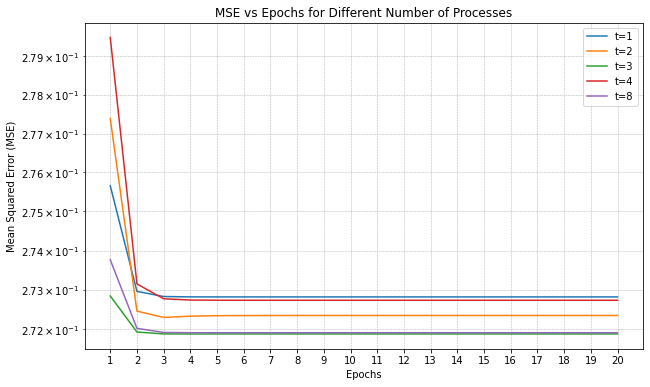

In [29]:
plot_mse_vs_epochs(X, y, 4, 0.001, 200000)